# IDS Bayesian Interferometry

In [1]:
import pymc3 as pm
import numpy as np
import scipy.io as sio

import matplotlib.pyplot as plt
from modelfunctions import *
%matplotlib inline

In [2]:
def show_fft_image(img_fft, shift = True, save = False , name = 'my_name.png'):
    
    img_fftabs = img_fft
    if type(img_fft[0,0]) == np.complex128:
        img_fftabs = np.abs(img_fft)
    
    if shift:
        img_fftabs = np.fft.fftshift(img_fftabs)
    plt.imshow(img_fftabs, cmap='viridis')
    plt.grid('off')
    
    if save:
        plt.savefig(name, format= 'png')

In [3]:
control = 1 # 0: sinthetic; 1: real

## Creating artificial data

[('name_3c286', 'O'), ('name_HD163296', 'O'), ('name_HLTau', 'O'), ('name_IRAS16293', 'O'), ('name_Juno9', 'O'), ('name_HD142527', 'O')]


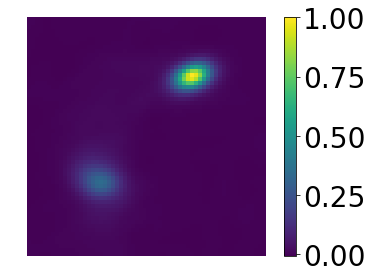

In [4]:
if control:
    path = '/home/lerko/Dataset_ALMA'
    fileName = 'Dataset_ALMA_11_07_17.mat'
    fullPath = path +'/' + fileName
    data = sio.loadmat(fullPath)
    
    img = data['Dataset']['name_IRAS16293'][0,0]['size_128x128'][0,0]
    IMAGE_SIZE_X, IMAGE_SIZE_Y = img.shape
    print(data['Dataset'].dtype)
elif not control:
    size = 3
    MAX_VALUE = 255
    MIN_VALUE = 0
    IMAGE_SIZE_X = 50
    IMAGE_SIZE_Y = 50
    SIGMA = 3*np.ones(size)

    I = np.array([1, 1, 1])
    Cx = np.array([25, 40, 10])
    Cy = np.array([25, 30, 10])

    minI = np.min(I)
    argminI = np.argmin(I)
    maxI = np.max(I)
    argmaxI = np.argmax(I)

    print('min I: %s at (%s,%s)\n' \
          'max I: %s at (%s,%s)\n' % (minI, Cx[argminI], Cy[argminI],
                                      maxI, Cx[argmaxI], Cy[argmaxI]))
    img = sintheticImage(I,Cx,Cy, l=SIGMA, IMAGE_SIZE_X = IMAGE_SIZE_X, IMAGE_SIZE_Y = IMAGE_SIZE_Y)
N0 = int(img.shape[0]/2 - 30)
Nf = int(img.shape[0]/2 + 30)

plt.imshow(img[N0+15:Nf+15,N0:Nf]/np.max(img), cmap='viridis')
plt.grid('off')
cbar = plt.colorbar(ticks=[0,0.25,0.5,0.75,1])
cbar.ax.tick_params(labelsize=28) 
plt.axis('off')
plt.tight_layout()
plt.savefig('zoom_fig1Original.pdf', format='pdf')

In [5]:
# Calculate the spectrum
img_fft, img_fftabs = spectrum(img)

## Creating sampling mask


For creating the sampling mask, we have made a u,v representations based on the antennas disposition. This is because, if the antennas disposition is random, the measures are not completely random. The Measurements positions are defined by the interferometry physics.

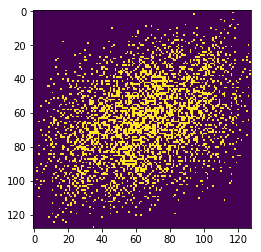

In [6]:
from masking import *

## Parameters
B_max = 1
antennas = 60
typeArray = 'URA'
sigma = B_max/6.0

lambda_phy=3*10**(-6); #(km)
H0=10; #(deg)
delta0=-30; #(deg)
Lat=34.05;  #(deg) Lat VLA

## Masking function returns the mask
mask = createSpectrumMasking(B_max,antennas,typeArray,sigma, lambda_phy, H0, delta0, Lat, N1 = IMAGE_SIZE_X, N2 = IMAGE_SIZE_Y)
show_fft_image(mask)

## Sampling

Variable `measurements` are the 2D representation for the measurements. `U` are the positions in the `u,v` spaces, i.e., `U[0] = u`, `U[1] = v`. Finally, `V` is the visibility function.

Percentage of measurements: 17.83447265625


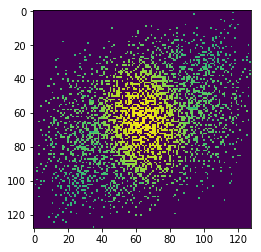

In [7]:
measurements,U,V = UVCreator(img_fft,mask)

measurements_abs = np.log(np.abs(measurements)+1e-12)
show_fft_image(measurements_abs)

p = 100*U.shape[0]/(measurements.shape[0]*measurements.shape[1]) 
print('Percentage of measurements: %s' % p)

## RBF Model
### Priors and Model

$$
V_{obs}(u,v) = \sum_{i=0}^{N_{b}-1}\alpha_i\phi_i(u,v)
$$

donde $\alpha_i \in \mathbb{R}$ y:

$$\phi_i(u,v) = \left[\begin{array}{c}
    \exp\big\lbrace\frac{-2\pi^2(u^2+v^2)}{1/l^2} \big\rbrace \cos \big\lbrace C_x^iu+C_y^iv\big\rbrace \\
    \exp\big\lbrace\frac{-2\pi^2(u^2+v^2)}{1/l^2} \big\rbrace \sin \big\lbrace C_x^iu+C_y^iv\big\rbrace
\end{array}\right]$$


$$
\phi_i(u,v) = 2 \pi \sigma^2 \exp \left(-2 \pi\left(j C_x^i u+jC_y^i v+\pi  \sigma^2\left(u^2+v^2\right)\right)\right) \vartheta _3\left(\pi  \left(2 j \pi  \sigma^2 u-C_x^i \right),e^{-2 \pi^2 \sigma^2}\right) \vartheta _3\left(\pi  \left(2 j \pi  \sigma^2 v-C_y^i\right),e^{-2 \pi^2 \sigma^2}\right)
$$


where:

$$
\vartheta_3 (q,z) = 1 + 2\sum_{n = 1}^{\infty} q^{n^2}\cos(2nz)
$$

In [8]:
import theano.tensor as tt

PI = np.pi
def Vobs_function(U,l,alpha,C, factor = None, IMAGE_SIZE_X = IMAGE_SIZE_X, IMAGE_SIZE_Y = IMAGE_SIZE_X):
    # We have implemented the model defined by:
    # V_obs = sum_{i=0}^{N_BASIS} alpha_i phi_i(u,v)
    # where phi_i(u,v) = exp(-2pi(u^2+v^2)l^2)exp(-j2pi(Cx^i u + Cv^i v))
    
    if factor == None:
        factorY = IMAGE_SIZE_Y
        factorX = IMAGE_SIZE_X
    
    # Rescale u,v space
    Uaux = U.astype('float32')
    
    Uaux[:,1] = U[:,1]# - IMAGE_SIZE_X/2
    Uaux[:,1] = Uaux[:,1]/factorX
    Uaux[:,0] = U[:,0]# - IMAGE_SIZE_Y/2
    Uaux[:,0] = Uaux[:,0]/factorY
#     print(u_aux)
    
    # Amplitud (Mantle o carrier)
    A = tt.exp(-2*np.pi**2*(tt.mul(Uaux,Uaux).sum(axis=1)*tt.pow(l[:,np.newaxis],2)))
#     A   = tt.outer(A_u,A_v)
#     print(A.eval().shape)
#     print(A.shape)
    
    # Imaginary Exponential (Mudolator)
    cosPart = tt.cos(-2*np.pi*tt.dot(C,Uaux.T))
    sinPart = tt.sin(-2*np.pi*tt.dot(C,Uaux.T))
#     print(cosPart.eval().shape)
#     imagExp = tt.exp(-2*np.pi*1j*(C*Uaux))
#     ## This is a outer multiplication between column's matrix
#     imagExp   = imagExp_u.dimshuffle(0, 1, 'x') * imagExp_v.dimshuffle(0, 'x', 1)
#     print(imagExp.eval().shape)
    
#     print((alpha*A*imagExp).eval().shape)
    ## Finally, alpha_i * phi_i
    out_real = (alpha[:,np.newaxis]*A*cosPart).sum(axis = 0)
    out_imag = (alpha[:,np.newaxis]*A*sinPart).sum(axis = 0)
#     out_real = tt.real(tt.sum(alpha[:,np.newaxis]*A*imagExp, axis = 0))
#     out_imag = tt.imag(tt.sum(alpha[:,np.newaxis]*A*imagExp, axis = 0))
    
#     print(imagExp.shape)


# print(cosPart.shape, sinPart.shape)    
    return out_real, out_imag

In [9]:
def matrix_points(U,V_real, V_imag, IMAGE_SIZE_X = IMAGE_SIZE_X, IMAGE_SIZE_Y = IMAGE_SIZE_X):
#     print(U.shape[0])
#     print(V_real.shape[0])
#     print(V_imag.shape[0])
    U = U.astype(int)
    out_real = np.zeros([IMAGE_SIZE_X, IMAGE_SIZE_Y])
    out_imag = np.zeros([IMAGE_SIZE_X, IMAGE_SIZE_Y])
    for i in range(U.shape[0]):
        out_real[U[i,0],U[i,1]] = V_real[i]
        out_imag[U[i,0],U[i,1]] = V_imag[i]
        
    return out_real, out_imag

In [10]:
if control == 0:
    numberOfSamplings = U.shape[0]
    numberOfBasis = size

    l = SIGMA
    init_alpha = I*l*np.sqrt(2*PI)
    init_C = np.stack([Cy,Cx], axis = 1)
    # print(init_C.shape)
    init_U = U.astype(int)

    u1 = np.arange((100))
    v1 = np.arange((100))

    myU = np.zeros((u1.shape[0]*v1.shape[0],2), dtype=np.int)
    k = 0
    for i in range(u1.shape[0]):
        for j in range(v1.shape[0]):
            myU[k,0] = u1[i]
            myU[k,1] = v1[j]
            k += 1

    PHI_Re, PHI_Im = Vobs_function(init_U,l,init_alpha,init_C,
                                   IMAGE_SIZE_X = IMAGE_SIZE_X, IMAGE_SIZE_Y= IMAGE_SIZE_Y)
    Im_pix_real, Im_pix_imag = matrix_points(U,V[:,0], V[:,1])
    Im_pix_fft = Im_pix_real + 1j*Im_pix_imag
    Im_pix = np.fft.ifft2(Im_pix_fft)
    fig, ax = plt.subplots(1,2)
    fig.set_figheight(10)
    fig.set_figwidth(8)
    ax[0].imshow( np.abs(Im_pix) , cmap = 'viridis')
    print(np.max(Im_pix))

    Im_ind_real, Im_ind_imag = matrix_points(init_U,PHI_Re.eval(), PHI_Im.eval(), IMAGE_SIZE_X=IMAGE_SIZE_X ,IMAGE_SIZE_Y=IMAGE_SIZE_Y)

    #Im_ind_real = ndimage.rotate(Im_ind_real, 90*2)
    #Im_ind_imag = ndimage.rotate(Im_ind_imag, 90*2)
    # Im_ind = np.log(np.sqrt(Im_ind_real*Im_ind_real+Im_ind_imag*Im_ind_imag) +1e-12)
    Im_ind_fft = Im_ind_real + 1j*Im_ind_imag
    # print(Im_ind_fft.shape)
    Im_ind = np.fft.ifft2(Im_ind_fft)
    #Im_ind = np.fft.fftshift(Im_ind)
    ax[1].imshow( np.abs(Im_ind) , cmap = 'viridis')
    # print(np.max(Im_ind))

    fig, ax = plt.subplots(2,2)
    ax[0,0].plot(np.abs(Im_pix[:,10]))
    ax[0,1].plot(np.abs(Im_ind[:,10]))
    ax[1,0].plot(np.abs(Im_pix[:,10]))
    ax[1,1].plot(np.abs(Im_ind[:,10]))
    plt.show()


    plt.imshow(Im_ind.real)
    plt.imshow(Im_ind.imag)

In [11]:
#from scipy import optimize
numberOfSamplings = U.shape[0]
numberOfBasis = 50
rbf_model = pm.Model()


l = 3*np.ones(numberOfBasis)
# init_Cx = IMAGE_SIZE_X*np.random.rand(numberOfBasis)
# init_Cy = IMAGE_SIZE_Y*np.random.rand(numberOfBasis)
init_C = np.array([IMAGE_SIZE_Y,IMAGE_SIZE_X])/2

beta_0 = 0.5
C_sd = IMAGE_SIZE_X/2
alpha_sd = 10

with rbf_model:
    alpha_model = pm.Normal('alpha', mu=0, sd=alpha_sd, shape = numberOfBasis)
#     alpha_s = pm.HalfNormal('alpha_s', sd=alpha_sd, shape = numberOfBasis)
#     alpha_model = pm.Normal('alpha', mu=0, sd=1./alpha_s, shape = numberOfBasis)
    
#     Cx_model = pm.Gamma('Cx', alpha=beta_0*(init_Cx)+1, beta=beta_0, shape = numberOfBasis)
#     Cy_model = pm.Gamma('Cy', alpha=beta_0*(init_Cy)+1, beta=beta_0, shape = numberOfBasis)
#     Cx_model = pm.Normal('Cx', mu=IMAGE_SIZE_X/2, sd=C_sd, shape = numberOfBasis)
#     Cx_model = pm.Uniform('Cx', lower=0, upper=IMAGE_SIZE_X, shape = numberOfBasis)
#     Cy_model = pm.Normal('Cy', mu=IMAGE_SIZE_Y/2, sd=C_s, shape = numberOfBasis)
#     Cy_model = pm.Uniform('Cy', lower=0, upper=IMAGE_SIZE_Y, shape = numberOfBasis)
    C_model = pm.Normal('C', mu=init_C, sd=C_sd*np.ones((1,2)), shape = (numberOfBasis,2))

    l_model = pm.Gamma('l', alpha = beta_0*l+2, beta=beta_0, shape = numberOfBasis)

    sd_dist = pm.Normal.dist(0,0.1)
    packed_chol = pm.LKJCholeskyCov('chol_cov', eta=2, n=2, sd_dist=sd_dist)
    chol = pm.expand_packed_triangular(2, packed_chol, lower=True)
    sigma_model = tt.dot(chol, chol.T)
    
    PHI_Re, PHI_Im = Vobs_function(U, l_model, alpha_model, C_model,
                                   IMAGE_SIZE_X=IMAGE_SIZE_X, IMAGE_SIZE_Y=IMAGE_SIZE_Y)
    V_model = tt.stack([PHI_Re, PHI_Im], axis = 1)

    V_obs = pm.MvNormal('V_obs', mu=V_model, cov=sigma_model, observed= V)
    
#     db = pm.backends.Text('test_log_normal')
    n_samples = 1000
    
#     step = pm.Metropolis()
#     step = pm.Slice()
#     step = pm.NUTS()
#     trace = pm.sample(n_samples, step)
    estimation = pm.find_MAP()
    print(estimation)

         Current function value: 13538.308568
         Iterations: 1433
         Function evaluations: 1560
         Gradient evaluations: 1548
{'alpha': array([ 5.59604218,  3.74419077, -0.07683829, -0.07300559, -0.07340665,
       -0.07434499, -0.04131749, -1.11462057, -0.074421  , -0.07224176,
       -0.07200672, -0.74315379, -0.07375114, -0.07234617, -0.07365099,
       -0.07346227, -0.0735615 , -0.0735364 , -0.07345213,  2.30270184,
       -0.07317266, -0.0737195 , -0.07355431, -0.07355883, -0.07447454,
       -0.07353269, -0.07548917, -0.07330756, -0.06795019,  6.54452046,
        0.55227407,  0.55582008,  2.26505927, -1.49211951,  0.54312798,
       -0.07436166,  1.51281481,  0.55929266,  3.89854839,  0.55394572,
        0.55532265,  0.5558011 , -0.07294562,  5.15265101, -0.06950725,
       -0.07063953,  1.29471738, -0.07282108, -0.0744844 , -0.06670665]), 'C': array([[ 89.98806451,  52.44922769],
       [ 88.4520048 ,  48.87917654],
       [ 63.67970325,  63.65908228],
       [

In [12]:
from scipy import stats
isMCMC = False

if isMCMC:
    n_burn = 300
    alpha_test_half = np.mean(trace['alpha'][n_burn:], axis=0)/np.sqrt(2*np.pi)
    C_test_half = np.mean(trace['C'][n_burn:], axis=0)
    l_test_half = np.mean(trace['l'][n_burn:], axis=0)

    pm.traceplot(trace[n_burn:])
else:
    alpha_test_half = estimation['alpha']/np.sqrt(2*np.pi)
    C_test_half = estimation['C']
    l_test_half = np.exp(estimation['l_log__'])
    
np.count_nonzero(alpha_test_half > 10e-3)

16

In [13]:
def sintheticImage(I, Cx, Cy, l, IMAGE_SIZE_X=256, IMAGE_SIZE_Y=256):
    n_Cx = Cx.shape[0]
    n_Cy = Cy.shape[0]
    n_I = I.shape[0]
    print(I.shape[0])
    assert n_Cx == n_Cy and n_Cx == n_I and n_Cy == n_I, 'Error dimension'
    Ns = n_I
    Im_out = np.zeros((IMAGE_SIZE_X, IMAGE_SIZE_Y))

    for i in range(Ns):
        for y in range(IMAGE_SIZE_Y):
            for x in range(IMAGE_SIZE_X):
                # print 'I(%i,%i) = %s' %(Cx[i],Cy[i],I[i]*psi(x,y,l,Cx[i],Cy[i]))
                Im_out[y][x] = Im_out[y][x] + I[i] * psi(x, y, l[i], Cx[i], Cy[i])
                # print Im_out[x][y]
    return Im_out

50


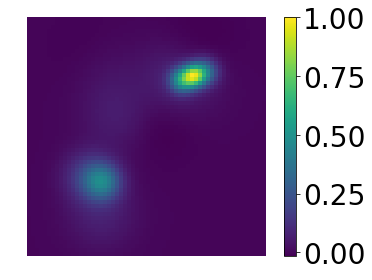

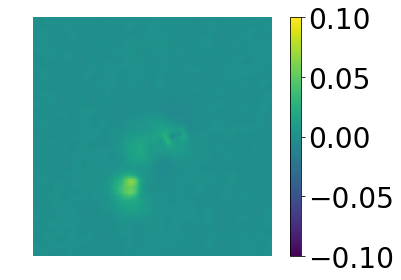

In [14]:
Im_reconstructed = sintheticImage(alpha_test_half,C_test_half[:,1], C_test_half[:,0], l_test_half, 
                                 IMAGE_SIZE_X=IMAGE_SIZE_X, IMAGE_SIZE_Y=IMAGE_SIZE_Y)
plt.figure()

plt.imshow(Im_reconstructed[N0+15:Nf+15,N0:Nf]/np.max(Im_reconstructed), cmap='viridis')
plt.grid('off')
cbar = plt.colorbar(ticks=[0,0.25,0.5,0.75,1])
cbar.ax.tick_params(labelsize=28) 
plt.axis('off')
plt.tight_layout()
plt.savefig('zoom_fig1.pdf', format='pdf')

plt.figure()
plt.imshow( np.max(img)*Im_reconstructed/np.max(Im_reconstructed) - img, cmap='viridis' , clim=(-0.1, 0.1))
plt.grid('off')
cbar = plt.colorbar(ticks=[-0.1,-0.05,0.000,0.05,0.1])
cbar.ax.tick_params(labelsize=28)
plt.axis('off')
plt.tight_layout()
# plt.savefig('residual_50basis_hierarchical.pdf', format='pdf')


In [15]:
from mpl_toolkits.axes_grid1 import make_axes_locatable
import seaborn as sns
# Set the font dictionaries (for plot title and axis titles)
title_font = {'size':'22', 'color':'black', 'weight':'normal',
              'verticalalignment':'bottom'}

Initial Conditions:
Number of Basis: 50; Number of Samplings: 2922
Cx,Cy: [[ 89.98806451  52.44922769]
 [ 88.4520048   48.87917654]
 [ 63.67970325  63.65908228]
 [ 63.69925573  63.67604088]
 [ 63.69707462  63.67520364]
 [ 63.69289013  63.67144476]
 [ 63.84913973  63.81982587]
 [ 55.64298643  76.17934641]
 [ 63.69241394  63.67120392]
 [ 63.70340873  63.67988314]
 [ 63.70132814  63.68420443]
 [ 57.67980974  49.94528212]
 [ 63.69383871  63.67504943]
 [ 63.70163827  63.68131325]
 [ 63.69534254  63.67455069]
 [ 63.69763107  63.67428367]
 [ 63.69701956  63.67401293]
 [ 63.69727247  63.67401327]
 [ 63.69749585  63.67441025]
 [ 98.14374915  52.09252517]
 [ 63.70034642  63.67478044]
 [ 63.69469587  63.67450753]
 [ 63.69707416  63.67402322]
 [ 63.69697582  63.67408019]
 [ 63.69688108  63.66780973]
 [ 63.69731421  63.67401332]
 [ 63.69073317  63.66371231]
 [ 63.69977385  63.67477997]
 [ 63.72366982  63.69892959]
 [ 63.1539735   75.46315525]
 [ 64.1748682   67.48105928]
 [ 64.17405478  67.50292018

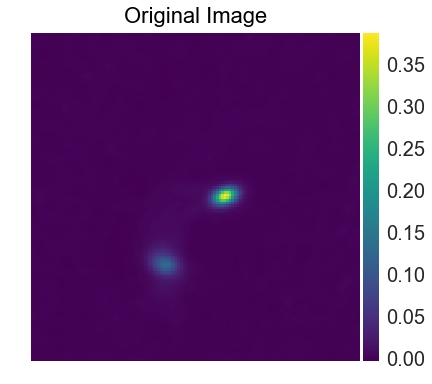

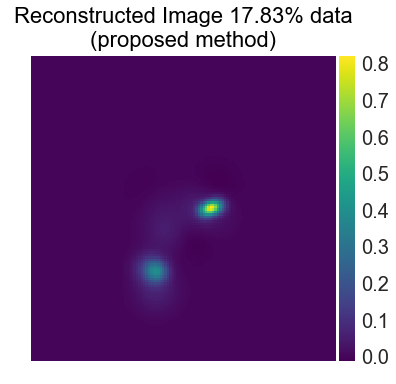

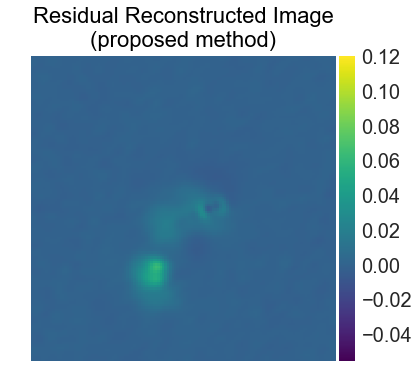

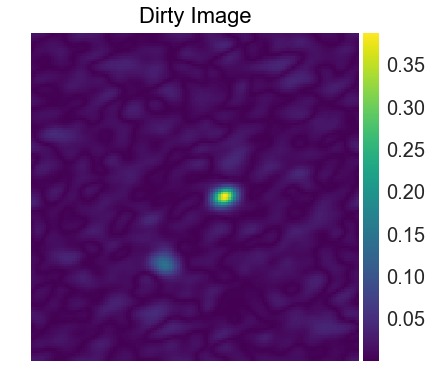

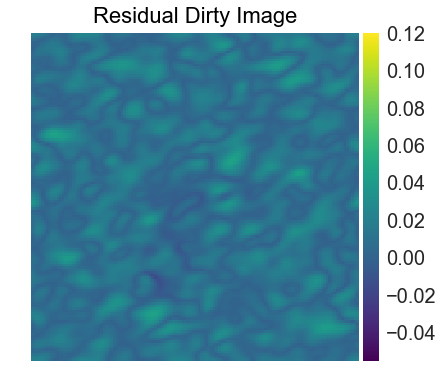

In [16]:
fig = plt.figure()
ax = plt.gca()
im = ax.imshow( img , cmap='viridis' )
ax.set_title('Original Image', **title_font)
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.05)
cbar = fig.colorbar(im, cax=cax)
cbar.ax.tick_params(labelsize=20) 
ax.axis('off')
plt.tight_layout()
#plt.savefig('imagen_original.pdf', format='pdf')

# alpha_test_half = estimation['alpha']/np.sqrt(2*np.pi)
# C_test_half = estimation['C']
# l_test_half = np.exp(estimation['l_log__'])

print('Initial Conditions:')
print('Number of Basis: %s; Number of Samplings: %s' % (numberOfBasis, numberOfSamplings))
print('Cx,Cy: %s; ' % (C_test_half)),
print('alpha: %s; ' % (alpha_test_half)),
print('l: %s' % l_test_half)


Im_reconstructed = sintheticImage(alpha_test_half,C_test_half[:,1], C_test_half[:,0], l_test_half, 
                                 IMAGE_SIZE_X=IMAGE_SIZE_X, IMAGE_SIZE_Y=IMAGE_SIZE_Y)

fig = plt.figure()
ax = plt.gca()
im = ax.imshow( Im_reconstructed , cmap='viridis' )
ax.set_title('Reconstructed Image {0}% data\n(proposed method)'.format(np.round(p,2)),**title_font)
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.05)

cbar = fig.colorbar(im, cax=cax)
cbar.ax.tick_params(labelsize=20) 
ax.axis('off')
plt.tight_layout()
#plt.savefig('imagen_reconstruction-70.pdf', format='pdf')


fig = plt.figure()
ax = plt.gca()
I_res = (Im_reconstructed*np.max(img)/np.max(Im_reconstructed) -  img)
print(np.min(I_res), np.max(I_res))
im = ax.imshow(I_res , cmap='viridis' , clim=(-0.0552899332572, 0.12))
ax.set_title('Residual Reconstructed Image\n(proposed method)', **title_font)
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.05)

cbar = fig.colorbar(im, cax=cax)
cbar.ax.tick_params(labelsize=20) 
ax.axis('off')

plt.tight_layout()
#plt.savefig('imagen_reconstruction-70_dif.pdf', format='pdf')


Im_pix_real, Im_pix_imag = matrix_points(U,V[:,0], V[:,1],
                                         IMAGE_SIZE_X= IMAGE_SIZE_X, IMAGE_SIZE_Y=IMAGE_SIZE_Y)
Im_pix_fft = Im_pix_real + 1j*Im_pix_imag
Im_pix = np.fft.ifft2(Im_pix_fft)
fig = plt.figure()
ax = plt.gca()
im = ax.imshow( np.max(img)*np.abs(Im_pix)/np.max(np.abs(Im_pix)) , cmap='viridis' )
ax.set_title('Dirty Image', **title_font)

divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.05)

cbar = fig.colorbar(im, cax=cax)
cbar.ax.tick_params(labelsize=20) 
ax.axis('off')

plt.tight_layout()
#plt.savefig('imagen_dirty-70.pdf', format='pdf')

fig = plt.figure()
ax = plt.gca()
im = ax.imshow( np.max(img)*np.abs(Im_pix)/np.max(np.abs(Im_pix)) - img, cmap='viridis' , clim=(-0.0552899332572, 0.12))
ax.set_title('Residual Dirty Image', **title_font)

divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.05)

cbar = fig.colorbar(im, cax=cax)
cbar.ax.tick_params(labelsize=20) 
ax.axis('off')

plt.tight_layout()
#plt.savefig('imagen_dirty-70-dif.pdf', format='pdf')

In [17]:
print(np.sum((Im_reconstructed*np.max(img)/np.max(Im_reconstructed) -  img)**2) )

0.398180667191


In [18]:
print(np.sum((np.max(img)*np.abs(Im_pix)/np.max(np.abs(Im_pix)) -  img)**2) )

3.16429514493
